In [1]:
import matplotlib.pyplot as plt
import numpy as np

A ideia para resolução do problema é da criação de níveis para cada novo item inserido na caixa. Cada nível corresponde à máxima caixa que poderia ser colocada a partir da extremidade esquerda superior de cada caixa. Para facilidade do código foi considerado apenas o espaço horizontal à direita.

In [2]:
# Função que atualizará os níveis sempre que um novo item é colocado
def atualiza_niveis(dict_bin,c_largura,c_altura):
    niveis = []
    aux = []
    for x in list(dict_bin.values()): 
        linha = x['linha2']
        if linha[1][1]==0: #Checa se toca solo
            aux.append(linha[0][0])
    comprimento = c_largura-max(aux)
    aux = [c_altura]
    for x in dict_bin.values():
        linha = x['linha3']
        if (linha[0][0]>c_largura-comprimento):
            aux.append(linha[1][0])
    altura = min(aux)
    ponto_inicial = [c_largura-comprimento,0]
    nivel={'comprimento':comprimento,'altura':altura,'ponto_inicial':ponto_inicial}
    niveis.append(nivel)
    for i in range(len(dict_bin.keys())):
        lista_aux = list(dict_bin.values())[i]
        ponto_inicial = [lista_aux['linha4'][0][1],lista_aux['linha4'][1][1]]
        aux = [c_largura-ponto_inicial[0]]
        for x in dict_bin.values():
            linha = x['linha4']
            if (x['linha1'][1][0]>ponto_inicial[1]) & (x['linha1'][0][1]>=ponto_inicial[0]):
                if linha[0][0]-ponto_inicial[0]>=0:
                    aux.append(linha[0][0]-ponto_inicial[0])
        comprimento = min(aux)
        aux = [c_altura-ponto_inicial[1]]
        for x in dict_bin.values():
            linha = x['linha3']
            if linha[0][0]>ponto_inicial[0] and linha[0][1]<lista_aux['linha1'][0][1]:
                if linha[1][0]-ponto_inicial[1]>=0:
                    aux.append(linha[1][0]-ponto_inicial[1])
        altura = min(aux)
        nivel={'comprimento':comprimento,'altura':altura,'ponto_inicial':ponto_inicial}
        niveis.append(nivel)
    return niveis

### Primeira Heurística - Simplesmente coloca os itens na caixa

In [3]:
def coloca_itens_na_caixa(c_largura, c_altura, itens, dict_itens,bins,niveis_caixas,dict_bins):
    #c_largura largura da caixa
    #c_altura altura da caixa
    #itens é uma lista com o nome dos itens
    #dict_itens dicionário que tem como chave o nome do item e como valores o comprimento e a altura do item
    # bins lista com o nome das caixas
    
    #dict_bins o que contém em cada bin
    
    for item in itens:
        comprimento,altura = dict_itens[item]['comprimento'], dict_itens[item]['altura']
        quebrar = False
        contador = 0
        for i in range(0,len(bins)): #bins = lista com o nome das caixas
            niveis = niveis_caixas[bins[i]] #niveis_caixa será um dicionário que guardará uma lista de dicionários com os níveis
            for nivel in niveis: #nivel será uma dicionario, niveis será uma lista 
                if comprimento<=nivel['comprimento'] and altura<=nivel['altura']:
                    x,y = nivel['ponto_inicial'][0],nivel['ponto_inicial'][1]
                    dict_bins[bins[i]][item]= {'linha1':[[x,x+comprimento],[y+altura,y+altura]],'linha2':[[x+comprimento,x+comprimento],[y+altura,y]],'linha3':[[x+comprimento,x],[y,y]],'linha4':[[x,x],[y,y+altura]]}
                    #atualizar niveis
                    #print(list(dict_bins[bins[i]].values()))
                    niveis_caixas[bins[i]] = atualiza_niveis(dict_bins[bins[i]],c_largura,c_altura)
                    quebrar = True
                    break
                #rotação
                elif altura<=nivel['comprimento'] and comprimento<=nivel['altura']:
                    x,y = nivel['ponto_inicial'][0],nivel['ponto_inicial'][1]
                    dict_bins[bins[i]][item]= {'linha1':[[x,x+altura],[y+comprimento,y+comprimento]],'linha2':[[x+altura,x+altura],[y+comprimento,y]],'linha3':[[x+altura,x],[y,y]],'linha4':[[x,x],[y,y+comprimento]]}
                    #atualizar niveis
                    #print(list(dict_bins[bins[i]].values()))
                    niveis_caixas[bins[i]] = atualiza_niveis(dict_bins[bins[i]],c_largura,c_altura)
                    quebrar = True
                    break     
            if quebrar:
                break
            contador+=1
        if contador == len(bins):
            bins.append(f'caixa{contador+1}')
            x,y = 0,0
            dict_bins[bins[-1]] = {}
            if comprimento<=c_largura and altura<=c_altura:
                dict_bins[bins[-1]][item]= {'linha1':[[x,x+comprimento],[y+altura,y+altura]],'linha2':[[x+comprimento,x+comprimento],[y+altura,y]],'linha3':[[x+comprimento,x],[y,y]],'linha4':[[x,x],[y,y+altura]]}    
                niveis_caixas[f'caixa{contador+1}'] = [{'comprimento': c_largura-comprimento,'altura':c_altura, 'ponto_inicial':[comprimento,0]},{'comprimento':c_largura,'altura':c_altura-altura,'ponto_inicial':[0,altura]}]
            elif altura<=c_largura and comprimento<=c_altura:
                dict_bins[bins[-1]][item]= {'linha1':[[x,x+altura],[y+comprimento,y+comprimento]],'linha2':[[x+altura,x+altura],[y+comprimento,y]],'linha3':[[x+altura,x],[y,y]],'linha4':[[x,x],[y,y+comprimento]]}    
                niveis_caixas[f'caixa{contador+1}'] = [{'comprimento': c_largura-altura,'altura':c_altura, 'ponto_inicial':[altura,0]},{'comprimento':c_largura,'altura':c_altura-comprimento,'ponto_inicial':[0,comprimento]}]
    custo = len(list(dict_bins.keys()))
    return dict_bins, niveis_caixas,custo

### Segunda Heurística - Coloca os maiores itens primeiro

In [4]:
def ordena_itens(dict_itens):
    #vamos organizar por área em ordem não-crescente
    dict_area = {item: dict_itens[item]['comprimento']*dict_itens[item]['altura'] for item in list(dict_itens.keys())}
    areas = list(dict_area.values())
    areas_ordem = sorted(areas, reverse = True)
    lista_indices = []
    for x in areas_ordem:
        lista_indices.append(areas.index(x))
        del areas[lista_indices[-1]]
        areas.insert(lista_indices[-1], 's')
    itens = [list(dict_area.keys())[ind] for ind in lista_indices]
    return itens

In [5]:
def coloca_itens_ordenados(c_largura, c_altura, itens, dict_itens,bins,niveis_caixas,dict_bins):
    itens = ordena_itens(dict_itens)
    dict_bins, niveis_caixas,custo = coloca_itens_na_caixa(c_largura, c_altura, itens, dict_itens,bins,niveis_caixas,dict_bins)
    return dict_bins, niveis_caixas, custo

### Terceira Heurística - tenta colocar primeiro nas caixa com menor espaço

In [6]:
def ordena_caixas(bins, niveis_caixas):
    sobras = {}
    for caixa in bins:
        niveis = niveis_caixas[caixa]
        resto = 0
        for nivel in niveis:
            resto += nivel['comprimento']*nivel['altura']
        sobras[caixa] = resto
    # Ordenar os bins
    areas = list(sobras.values())
    areas_ordem = sorted(areas, reverse = True)
    lista_indices = []
    for x in areas_ordem:
        lista_indices.append(areas.index(x))
        del areas[lista_indices[-1]]
        areas.insert(lista_indices[-1], 's')
    bins_novo = [list(sobras.keys())[ind] for ind in lista_indices]
    return bins_novo

In [7]:
def coloca_itens_na_caixa_ordenada(c_largura, c_altura, itens, dict_itens,bins,niveis_caixas,dict_bins):
    #c_largura largura da caixa
    #c_altura altura da caixa
    #itens é uma lista com o nome dos itens
    #dict_itens dicionário que tem como chave o nome do item e como valores o comprimento e a altura do item
    # bins lista com o nome das caixas
    
    #dict_bins o que contém em cada bin
    
    for item in itens:
        comprimento,altura = dict_itens[item]['comprimento'], dict_itens[item]['altura']
        quebrar = False
        contador = 0
        bins = ordena_caixas(bins, niveis_caixas)
        for caixa in bins: #bins = lista com o nome das caixas
            niveis = niveis_caixas[caixa] #niveis_caixa será um dicionário que guardará uma lista de dicionários com os níveis
            for nivel in niveis: #nivel será uma dicionario, niveis será uma lista 
                if comprimento<=nivel['comprimento'] and altura<=nivel['altura']:
                    x,y = nivel['ponto_inicial'][0],nivel['ponto_inicial'][1]
                    dict_bins[caixa][item]= {'linha1':[[x,x+comprimento],[y+altura,y+altura]],'linha2':[[x+comprimento,x+comprimento],[y+altura,y]],'linha3':[[x+comprimento,x],[y,y]],'linha4':[[x,x],[y,y+altura]]}
                    #atualizar niveis
                    niveis_caixas[caixa] = atualiza_niveis(dict_bins[caixa],c_largura,c_altura)
                    quebrar = True
                    break
                #rotação
                elif altura<=nivel['comprimento'] and comprimento<=nivel['altura']:
                    x,y = nivel['ponto_inicial'][0],nivel['ponto_inicial'][1]
                    dict_bins[caixa][item]= {'linha1':[[x,x+altura],[y+comprimento,y+comprimento]],'linha2':[[x+altura,x+altura],[y+comprimento,y]],'linha3':[[x+altura,x],[y,y]],'linha4':[[x,x],[y,y+comprimento]]}
                    #atualizar niveis
                    niveis_caixas[caixa] = atualiza_niveis(dict_bins[caixa],c_largura,c_altura)
                    quebrar = True
                    break     
            if quebrar:
                break
            contador+=1
        if contador == len(bins):
            bins.append(f'caixa{contador+1}')
            x,y = 0,0
            dict_bins[bins[-1]] = {}
            if comprimento<=c_largura and altura<=c_altura:
                dict_bins[bins[-1]][item]= {'linha1':[[x,x+comprimento],[y+altura,y+altura]],'linha2':[[x+comprimento,x+comprimento],[y+altura,y]],'linha3':[[x+comprimento,x],[y,y]],'linha4':[[x,x],[y,y+altura]]}    
                niveis_caixas[f'caixa{contador+1}'] = [{'comprimento': c_largura-comprimento,'altura':c_altura, 'ponto_inicial':[comprimento,0]},{'comprimento':c_largura,'altura':c_altura-altura,'ponto_inicial':[0,altura]}]
            elif altura<=c_largura and comprimento<=c_altura:
                dict_bins[bins[-1]][item]= {'linha1':[[x,x+altura],[y+comprimento,y+comprimento]],'linha2':[[x+altura,x+altura],[y+comprimento,y]],'linha3':[[x+altura,x],[y,y]],'linha4':[[x,x],[y,y+comprimento]]}    
                niveis_caixas[f'caixa{contador+1}'] = [{'comprimento': c_largura-altura,'altura':c_altura, 'ponto_inicial':[altura,0]},{'comprimento':c_largura,'altura':c_altura-comprimento,'ponto_inicial':[0,comprimento]}]
    custo = len(list(dict_bins.keys()))
    return dict_bins, niveis_caixas,custo

### Heurística 4 - Ordena os itens e ordena as caixas

In [8]:
def coloca_itens_ordenados_na_caixa_ordenada(c_largura, c_altura, itens, dict_itens,bins,niveis_caixas,dict_bins):
    #c_largura largura da caixa
    #c_altura altura da caixa
    #itens é uma lista com o nome dos itens
    #dict_itens dicionário que tem como chave o nome do item e como valores o comprimento e a altura do item
    # bins lista com o nome das caixas
    
    #dict_bins o que contém em cada bin
    itens = ordena_itens(dict_itens)
    for item in itens:
        comprimento,altura = dict_itens[item]['comprimento'], dict_itens[item]['altura']
        quebrar = False
        contador = 0
        bins = ordena_caixas(bins, niveis_caixas)
        for caixa in bins: #bins = lista com o nome das caixas
            niveis = niveis_caixas[caixa] #niveis_caixa será um dicionário que guardará uma lista de dicionários com os níveis
            for nivel in niveis: #nivel será uma dicionario, niveis será uma lista 
                if comprimento<=nivel['comprimento'] and altura<=nivel['altura']:
                    x,y = nivel['ponto_inicial'][0],nivel['ponto_inicial'][1]
                    dict_bins[caixa][item]= {'linha1':[[x,x+comprimento],[y+altura,y+altura]],'linha2':[[x+comprimento,x+comprimento],[y+altura,y]],'linha3':[[x+comprimento,x],[y,y]],'linha4':[[x,x],[y,y+altura]]}
                    #atualizar niveis
                    niveis_caixas[caixa] = atualiza_niveis(dict_bins[caixa],c_largura,c_altura)
                    quebrar = True
                    break
                #rotação
                elif altura<=nivel['comprimento'] and comprimento<=nivel['altura']:
                    x,y = nivel['ponto_inicial'][0],nivel['ponto_inicial'][1]
                    dict_bins[caixa][item]= {'linha1':[[x,x+altura],[y+comprimento,y+comprimento]],'linha2':[[x+altura,x+altura],[y+comprimento,y]],'linha3':[[x+altura,x],[y,y]],'linha4':[[x,x],[y,y+comprimento]]}
                    #atualizar niveis
                    niveis_caixas[caixa] = atualiza_niveis(dict_bins[caixa],c_largura,c_altura)
                    quebrar = True
                    break     
            if quebrar:
                break
            contador+=1
        if contador == len(bins):
            bins.append(f'caixa{contador+1}')
            x,y = 0,0
            dict_bins[bins[-1]] = {}
            if comprimento<=c_largura and altura<=c_altura:
                dict_bins[bins[-1]][item]= {'linha1':[[x,x+comprimento],[y+altura,y+altura]],'linha2':[[x+comprimento,x+comprimento],[y+altura,y]],'linha3':[[x+comprimento,x],[y,y]],'linha4':[[x,x],[y,y+altura]]}    
                niveis_caixas[f'caixa{contador+1}'] = [{'comprimento': c_largura-comprimento,'altura':c_altura, 'ponto_inicial':[comprimento,0]},{'comprimento':c_largura,'altura':c_altura-altura,'ponto_inicial':[0,altura]}]
            elif altura<=c_largura and comprimento<=c_altura:
                dict_bins[bins[-1]][item]= {'linha1':[[x,x+altura],[y+comprimento,y+comprimento]],'linha2':[[x+altura,x+altura],[y+comprimento,y]],'linha3':[[x+altura,x],[y,y]],'linha4':[[x,x],[y,y+comprimento]]}    
                niveis_caixas[f'caixa{contador+1}'] = [{'comprimento': c_largura-altura,'altura':c_altura, 'ponto_inicial':[altura,0]},{'comprimento':c_largura,'altura':c_altura-comprimento,'ponto_inicial':[0,comprimento]}]
    custo = len(list(dict_bins.keys()))
    return dict_bins, niveis_caixas,custo

### Função para plotar soluções 

In [9]:
def plota_bin(dict_bin,titulo1,titulo2,c_largura,c_altura):
    for item in list(dict_bin.keys()):
        for linha in ['linha1','linha2','linha3','linha4']:
            plt.plot(dict_bin[item][linha][0],dict_bin[item][linha][1],marker='o',color='r')
    plt.axis([0,c_largura,0,c_altura])
    plt.title(titulo1)
    plt.savefig(titulo2+'.jpeg')
    plt.show()

In [10]:
# Lendo instância

In [11]:
with open('instancia_bi.text','r') as f:
    instancia = f.readlines()

In [12]:
dados = list(map(lambda x: x.strip().split(' ') ,instancia))

In [13]:
dict_itens = {item: {'comprimento':int(comprimento),'altura':int(altura)} for item,comprimento,altura in dados}

In [14]:
# Cria solver

In [15]:
def solver(tipo, c_largura, c_altura, itens, dict_itens,bins,niveis_caixas,dict_bins):
    if tipo == 1:
        dict_bins, niveis_custo, custo = coloca_itens_na_caixa(c_largura, c_altura, itens, dict_itens,bins,niveis_caixas,dict_bins)
    elif tipo == 2:
        dict_bins, niveis_custo, custo = coloca_itens_ordenados(c_largura, c_altura, itens, dict_itens,bins,niveis_caixas,dict_bins)
    elif tipo ==3:
        dict_bins, niveis_custo, custo = coloca_itens_na_caixa_ordenada(c_largura, c_altura, itens, dict_itens,bins,niveis_caixas,dict_bins)
    elif tipo == 4:
        dict_bins, niveis_custo, custo = coloca_itens_ordenados_na_caixa_ordenada(c_largura, c_altura, itens, dict_itens,bins,niveis_caixas,dict_bins)
    return dict_bins, niveis_custo, custo

In [16]:
c_largura, c_altura = 20, 15
itens = [f'item{i}' for i in range(len(dict_itens.keys()))]
bins = ['caixa1']
niveis_caixas = {'caixa1':[{'comprimento': c_largura,'altura':c_altura,'ponto_inicial':[0,0]}]}
dict_bins = {'caixa1': {}}

In [17]:
tipo = 1
dict_bins, niveis_custo, custo = solver(tipo, c_largura, c_altura, itens, dict_itens,bins,niveis_caixas,dict_bins)

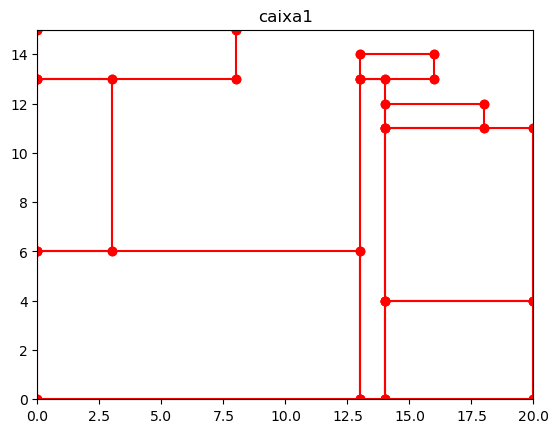

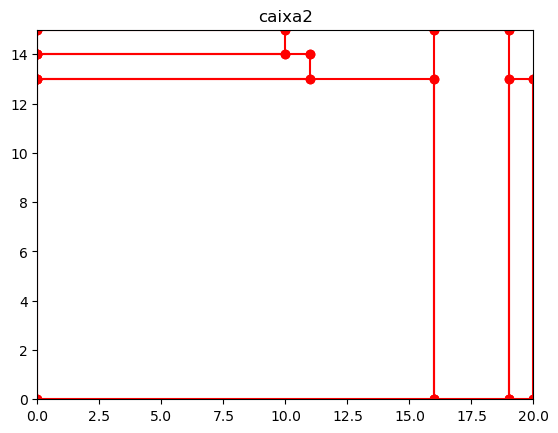

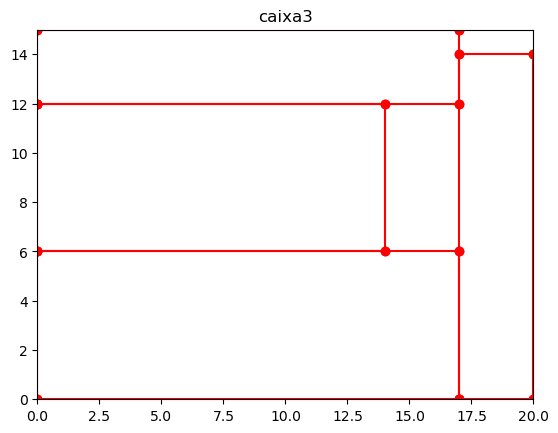

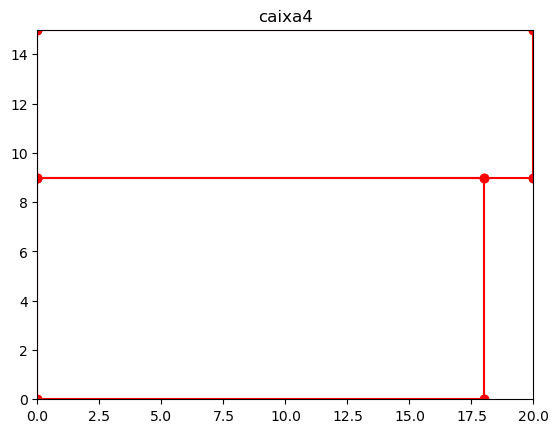

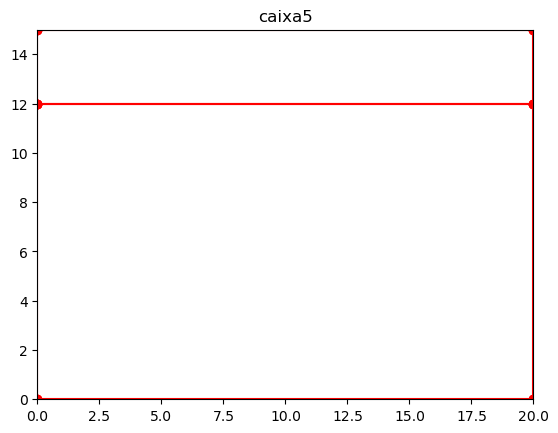

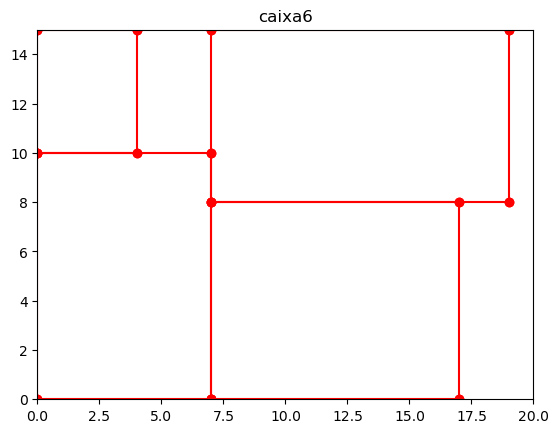

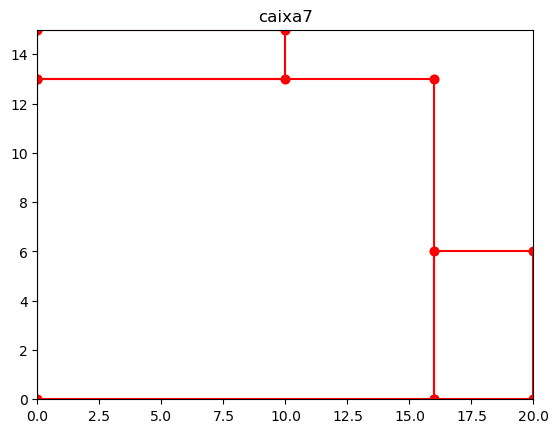

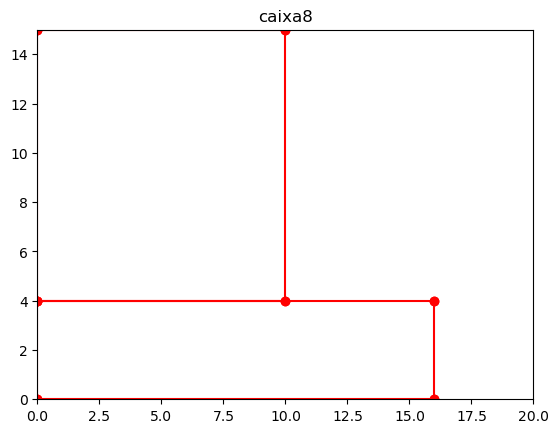

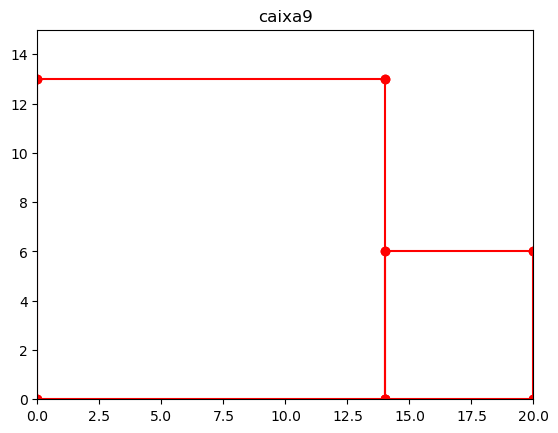

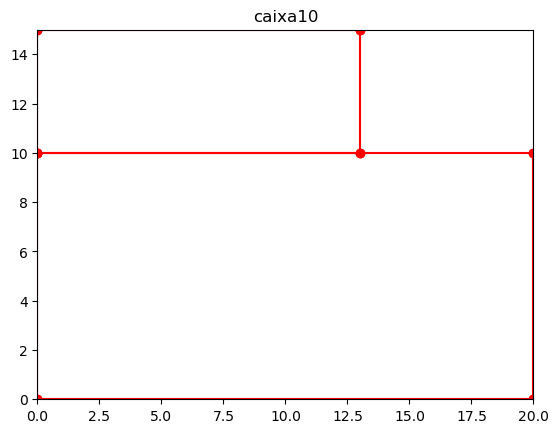

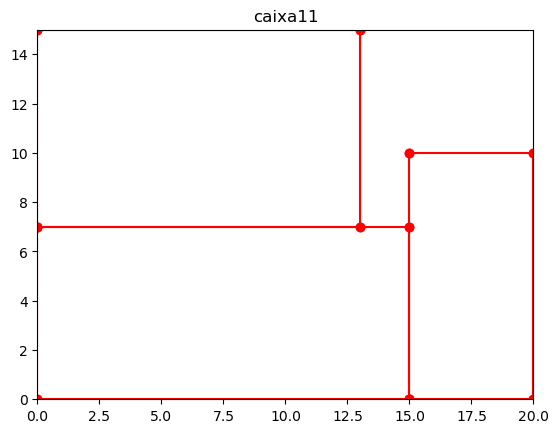

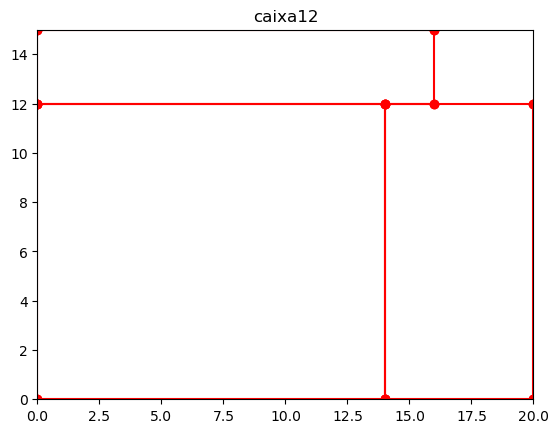

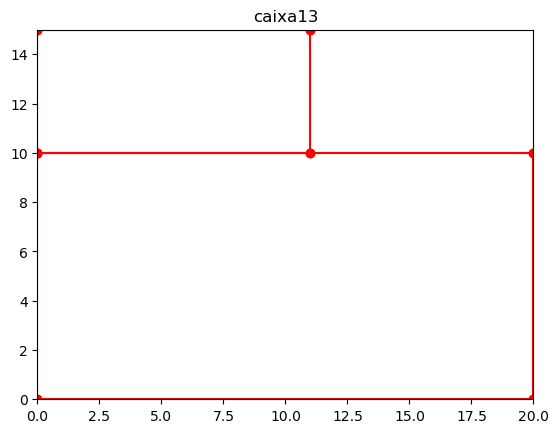

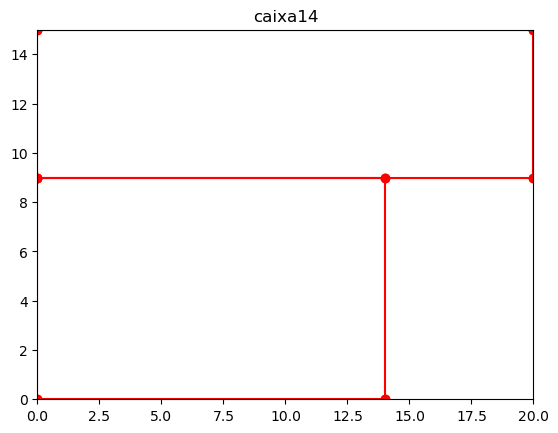

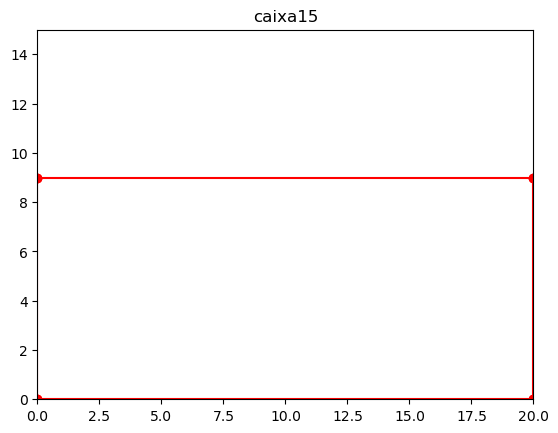

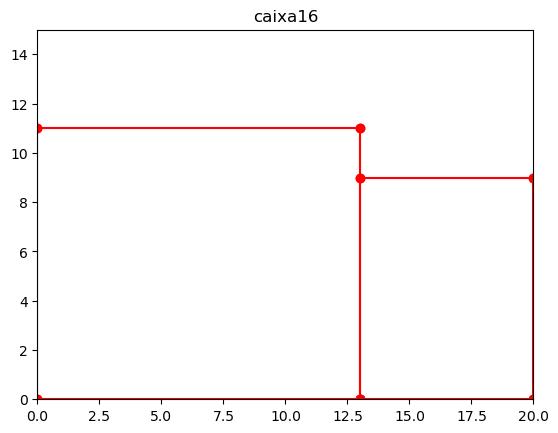

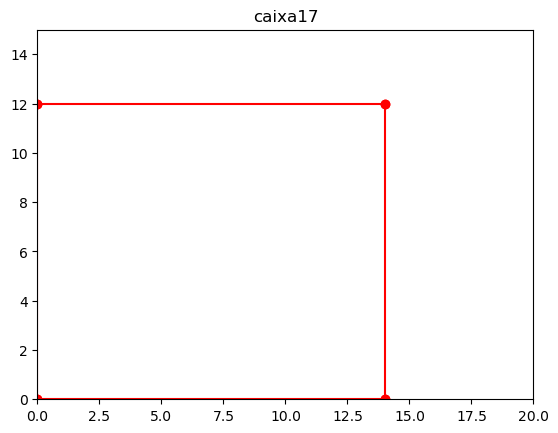

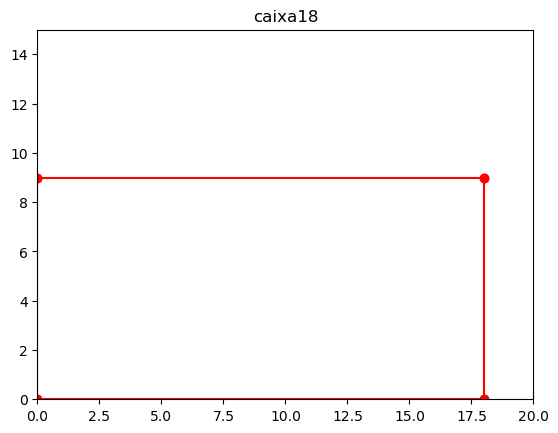

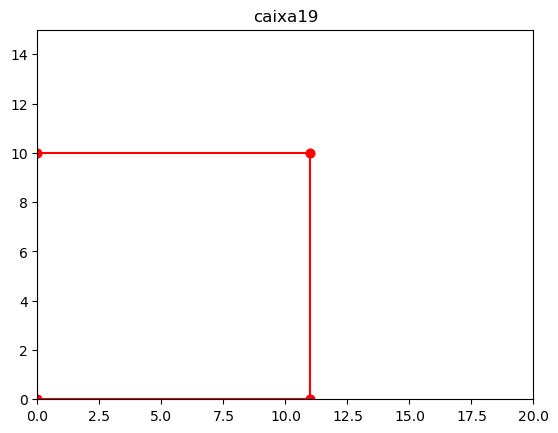

In [18]:
for caixa in list(dict_bins.keys()):
    plota_bin(dict_bins[caixa],caixa,'imagens/heuristica1/'+caixa,c_largura,c_altura)

In [19]:
c_largura, c_altura = 20, 15
itens = [f'item{i}' for i in range(len(dict_itens.keys()))]
bins = ['caixa1']
niveis_caixas = {'caixa1':[{'comprimento': c_largura,'altura':c_altura,'ponto_inicial':[0,0]}]}
dict_bins = {'caixa1': {}}

In [20]:
tipo = 2
dict_bins, niveis_custo, custo = solver(tipo, c_largura, c_altura, itens, dict_itens,bins,niveis_caixas,dict_bins)

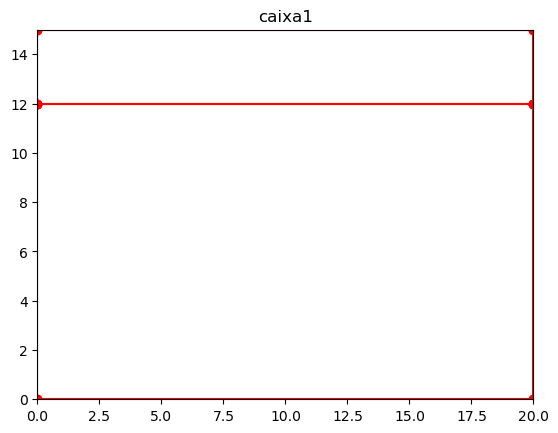

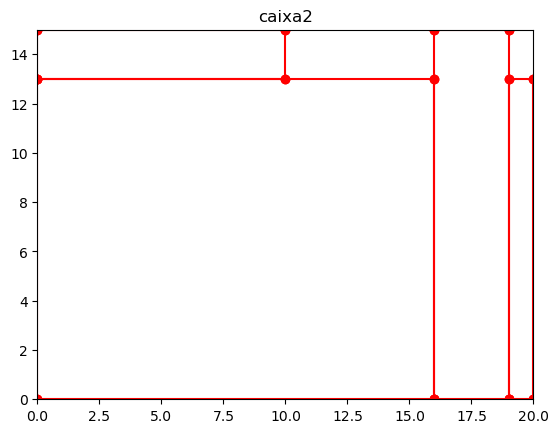

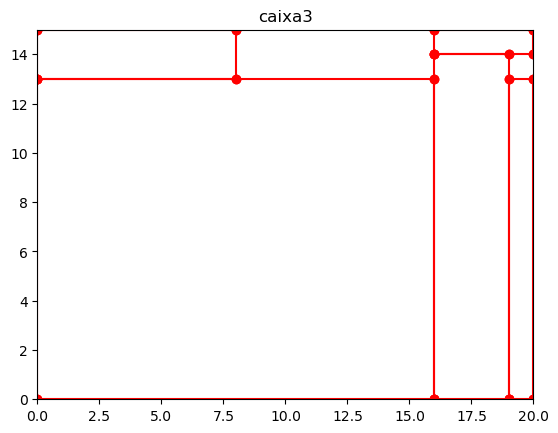

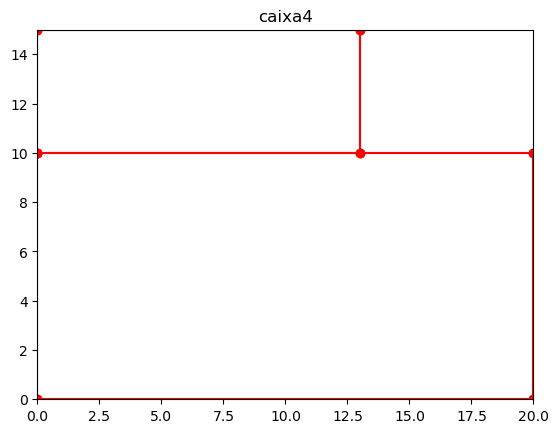

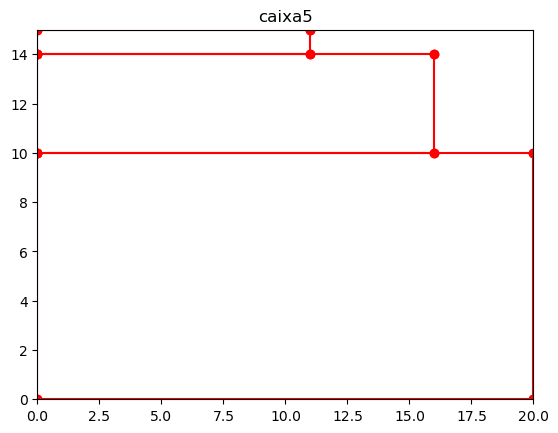

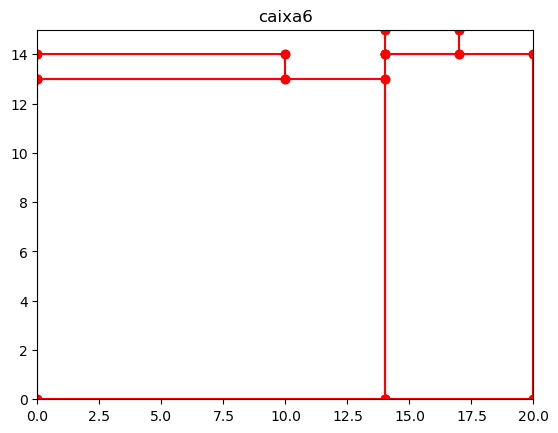

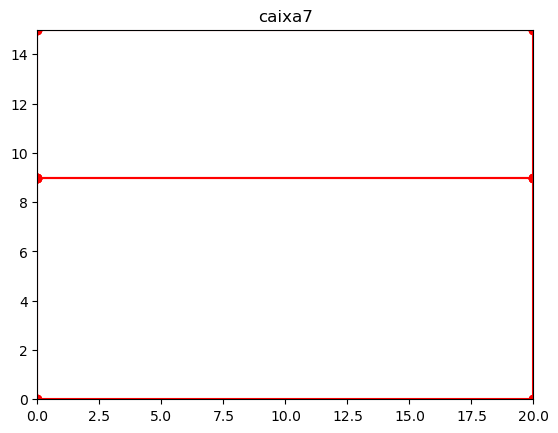

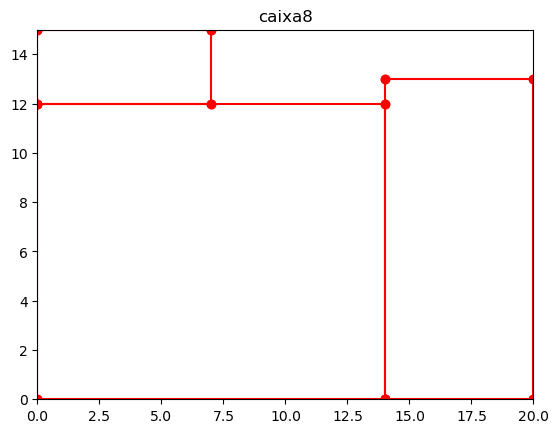

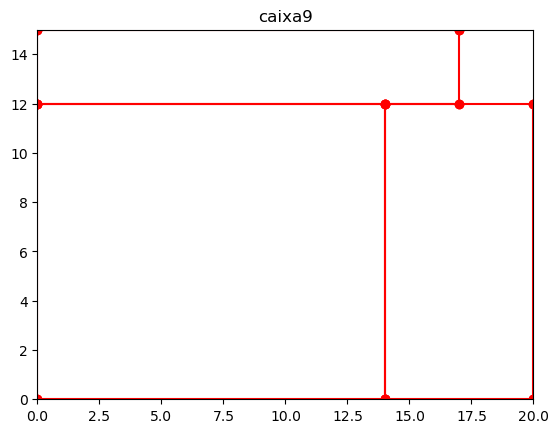

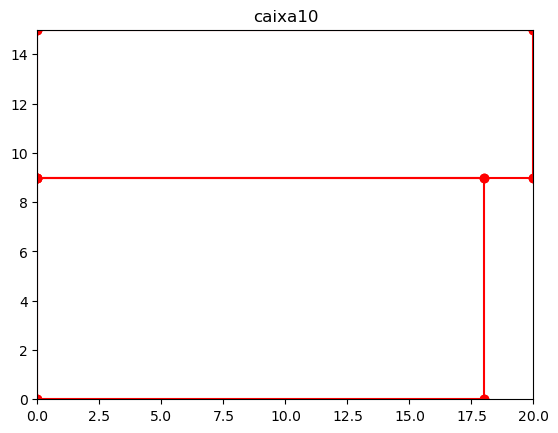

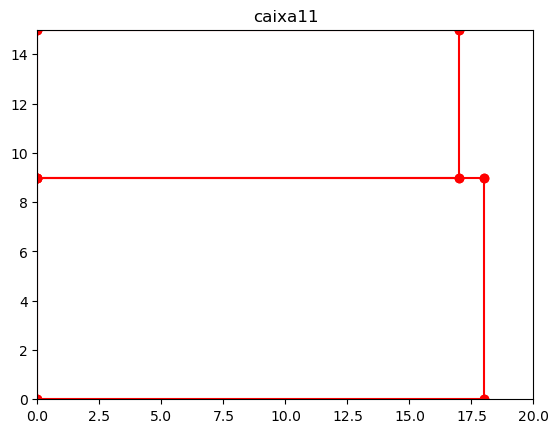

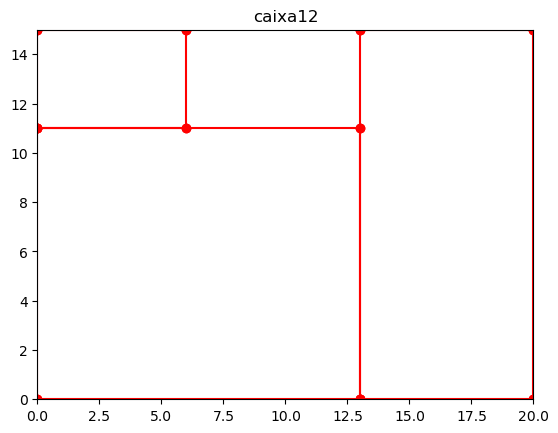

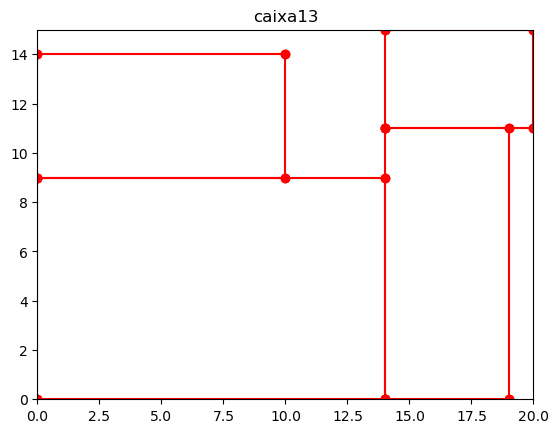

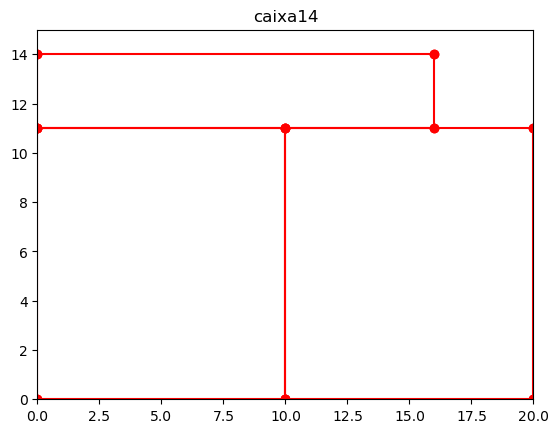

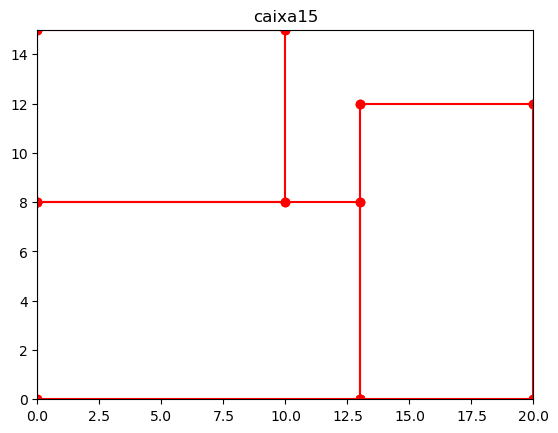

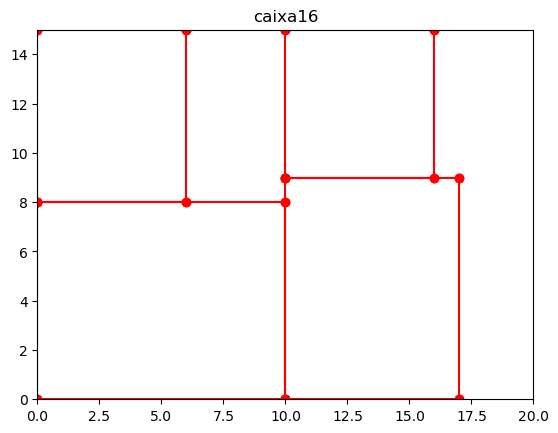

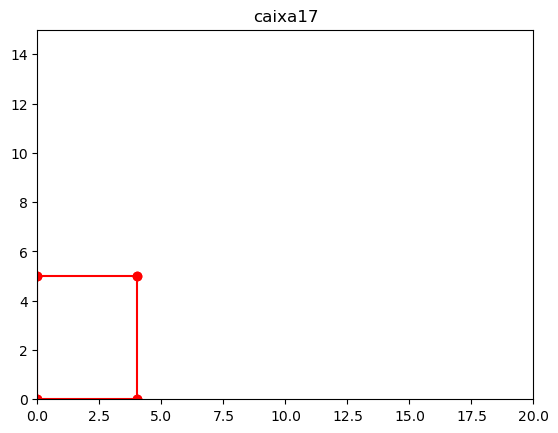

In [21]:
for caixa in list(dict_bins.keys()):
    plota_bin(dict_bins[caixa],caixa,'imagens/heuristica2/'+caixa,c_largura,c_altura)

In [22]:
c_largura, c_altura = 20, 15
itens = [f'item{i}' for i in range(len(dict_itens.keys()))]
bins = ['caixa1']
niveis_caixas = {'caixa1':[{'comprimento': c_largura,'altura':c_altura,'ponto_inicial':[0,0]}]}
dict_bins = {'caixa1': {}}

In [23]:
tipo = 3
dict_bins, niveis_custo, custo = solver(tipo, c_largura, c_altura, itens, dict_itens,bins,niveis_caixas,dict_bins)

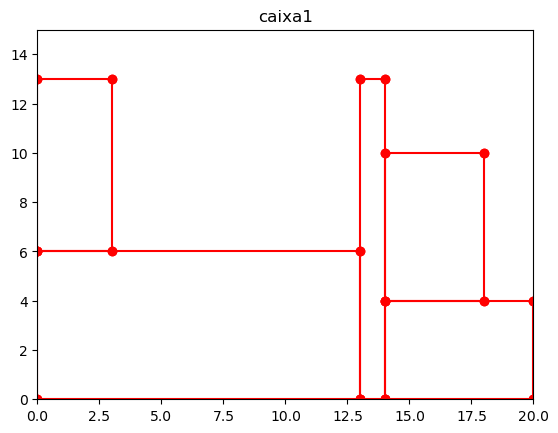

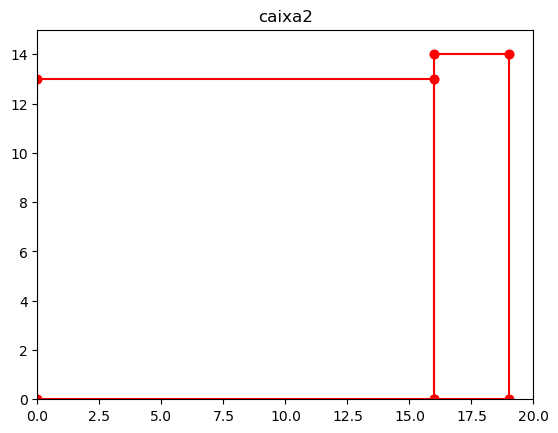

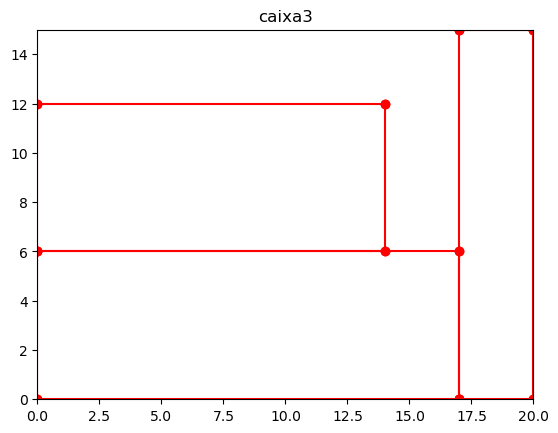

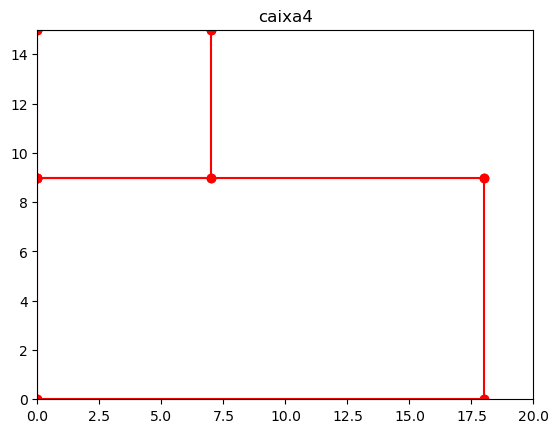

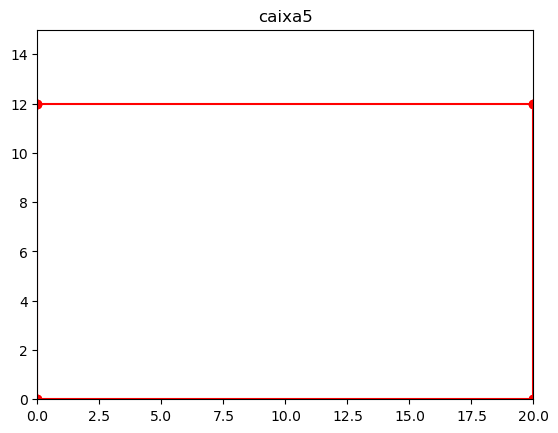

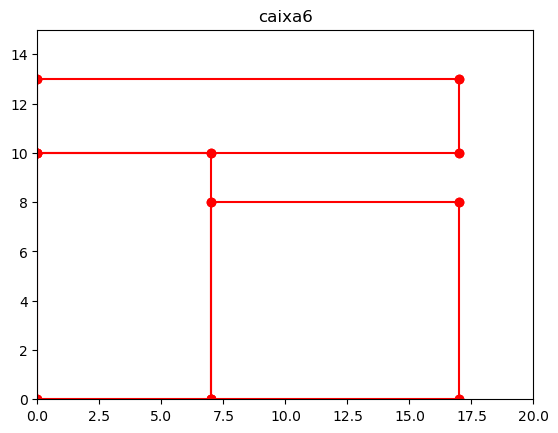

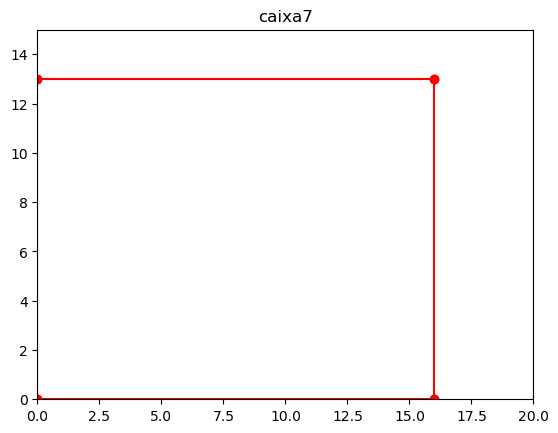

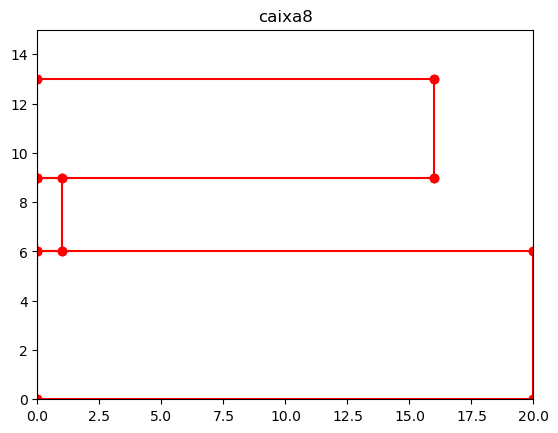

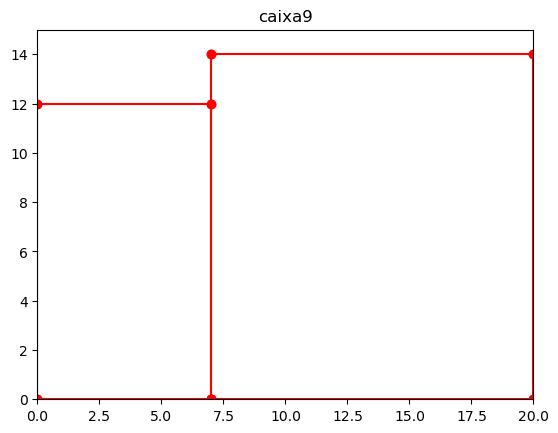

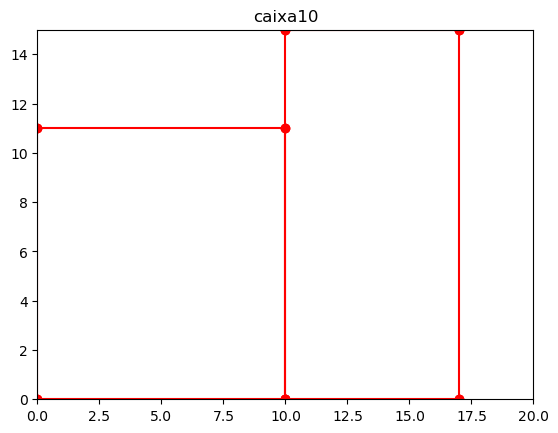

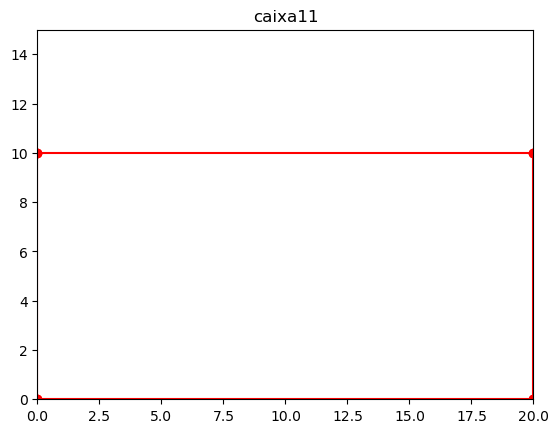

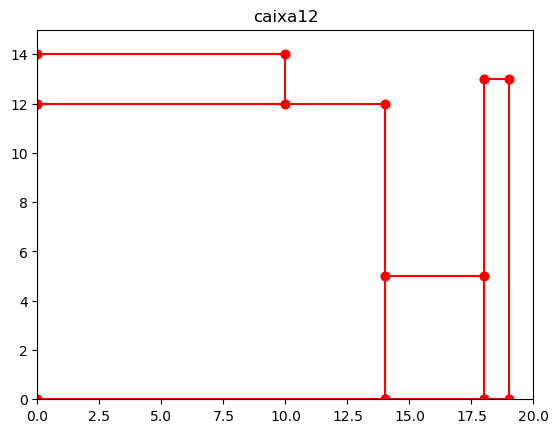

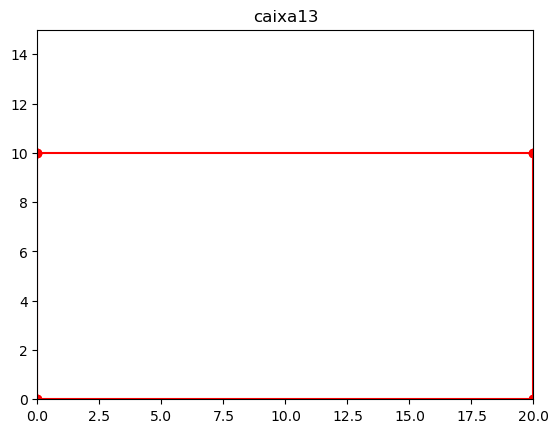

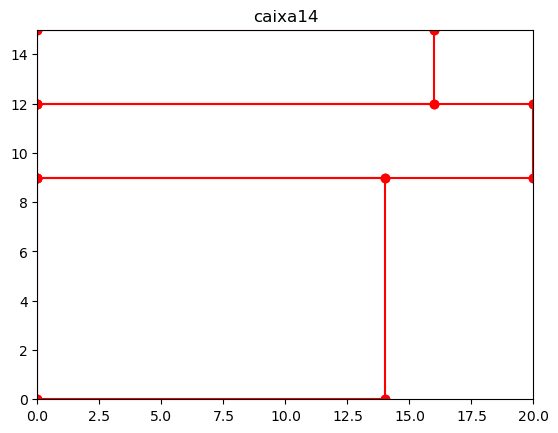

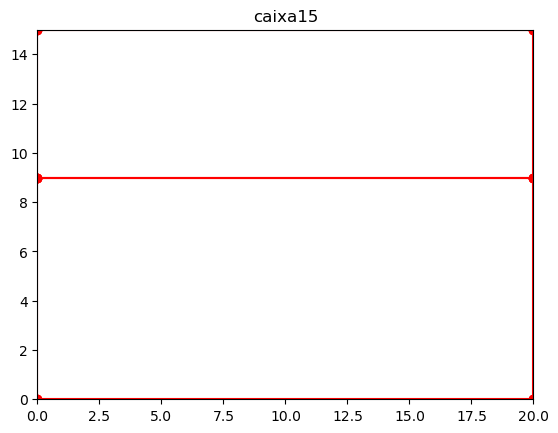

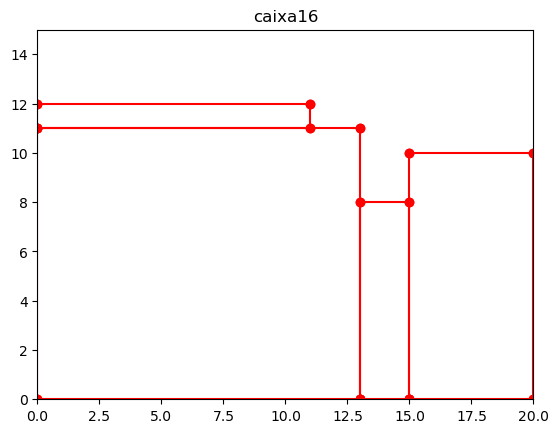

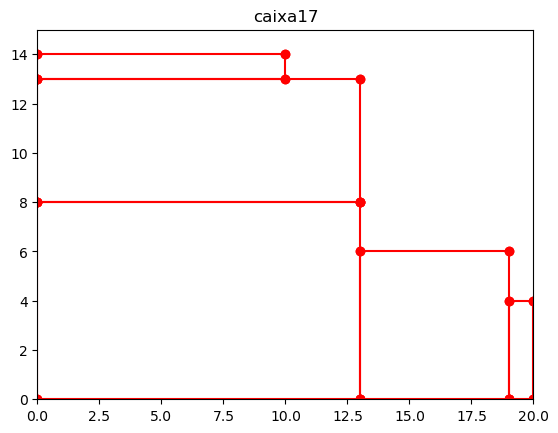

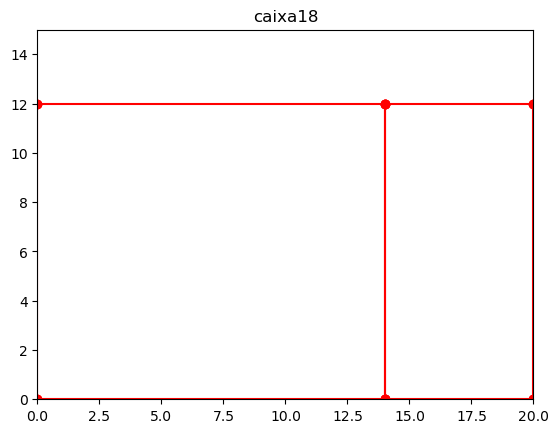

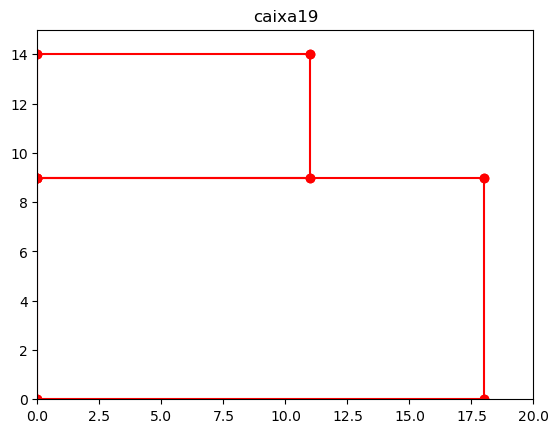

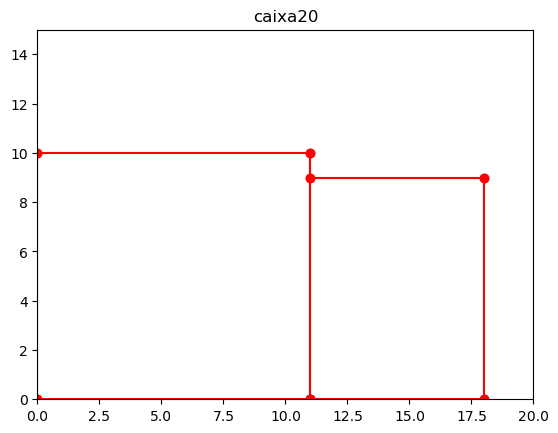

In [24]:
for caixa in list(dict_bins.keys()):
    plota_bin(dict_bins[caixa],caixa,'imagens/heuristica3/'+caixa,c_largura,c_altura)

In [25]:
print(custo)

20


In [26]:
c_largura, c_altura = 20, 15
itens = [f'item{i}' for i in range(len(dict_itens.keys()))]
bins = ['caixa1']
niveis_caixas = {'caixa1':[{'comprimento': c_largura,'altura':c_altura,'ponto_inicial':[0,0]}]}
dict_bins = {'caixa1': {}}

In [27]:
tipo = 4
dict_bins, niveis_custo, custo = solver(tipo, c_largura, c_altura, itens, dict_itens,bins,niveis_caixas,dict_bins)

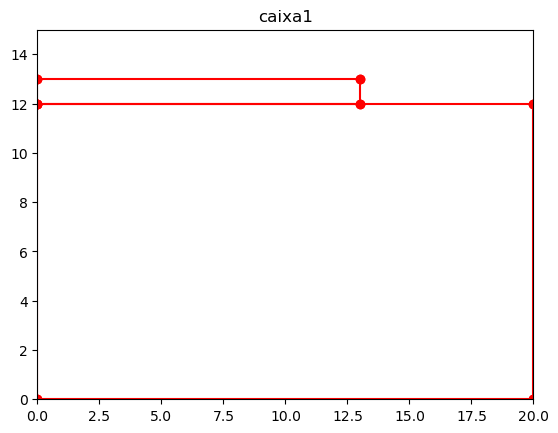

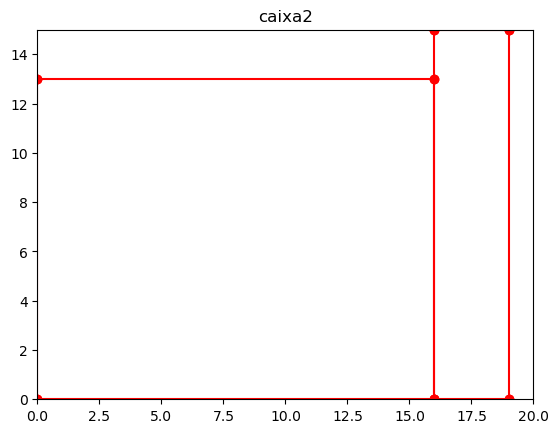

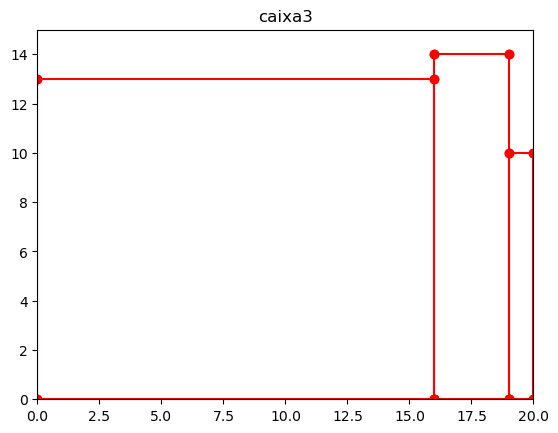

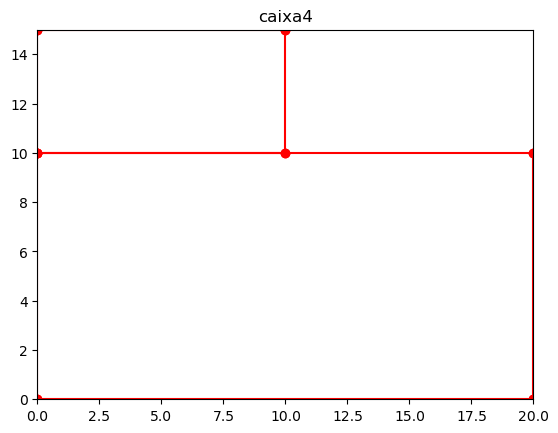

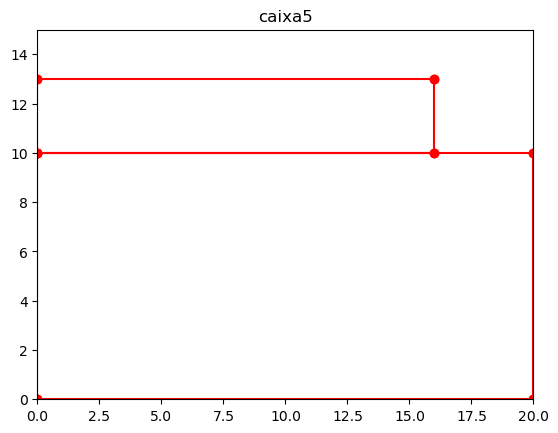

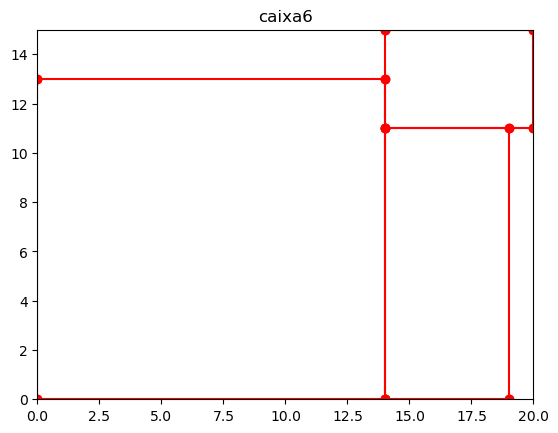

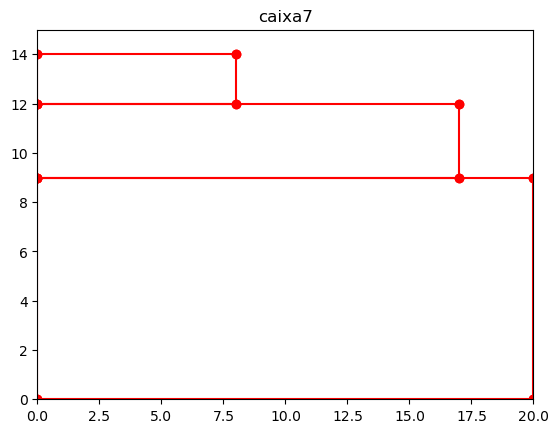

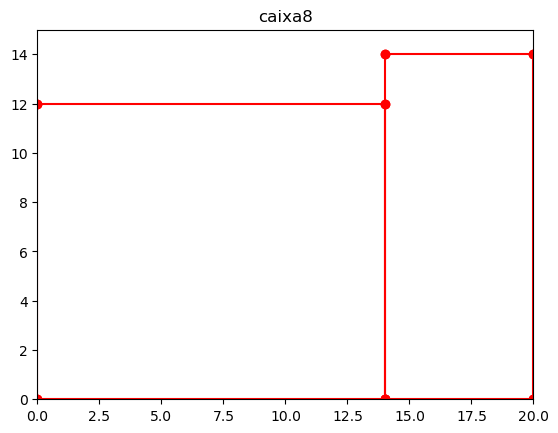

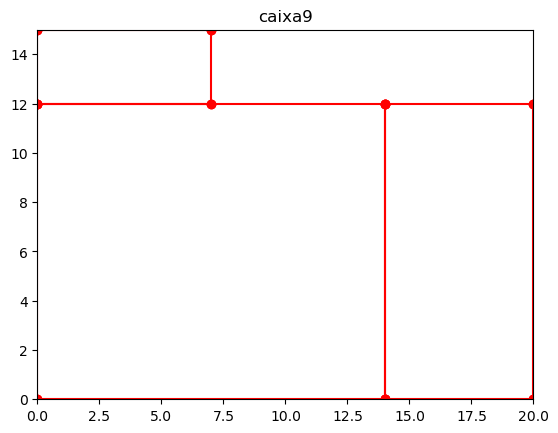

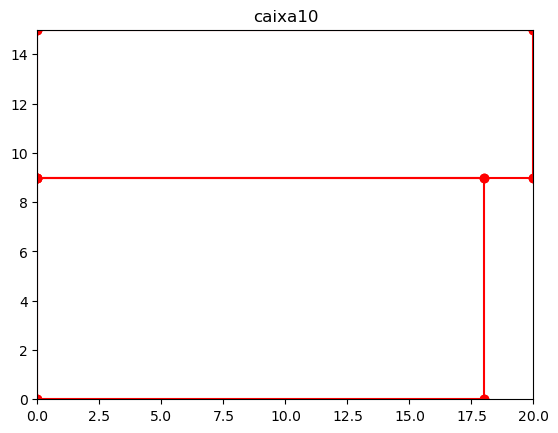

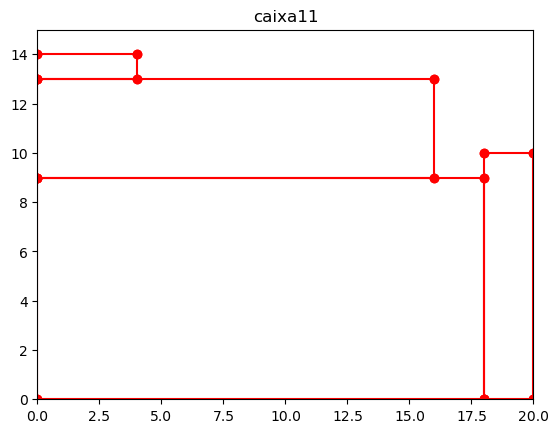

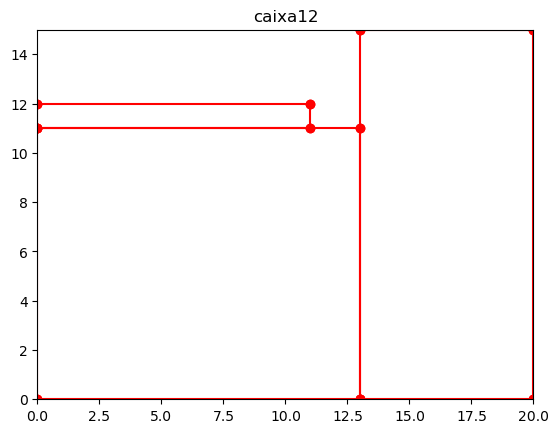

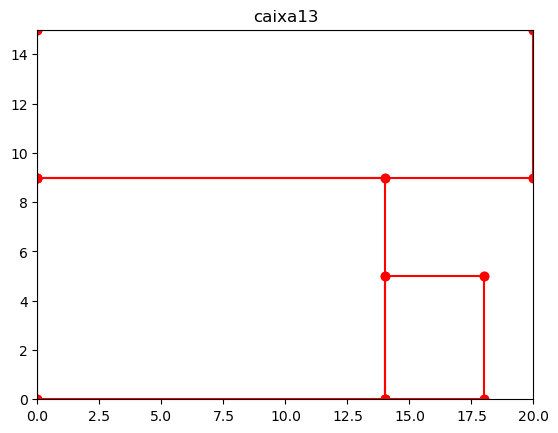

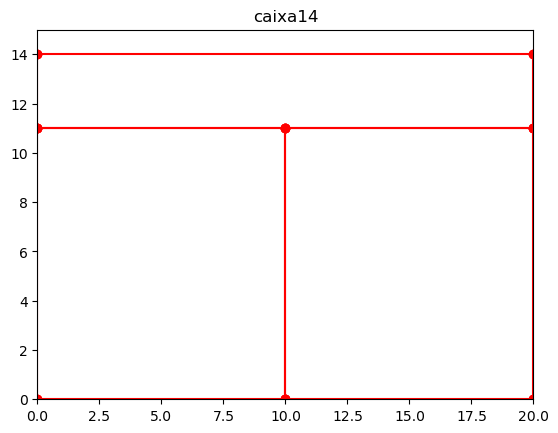

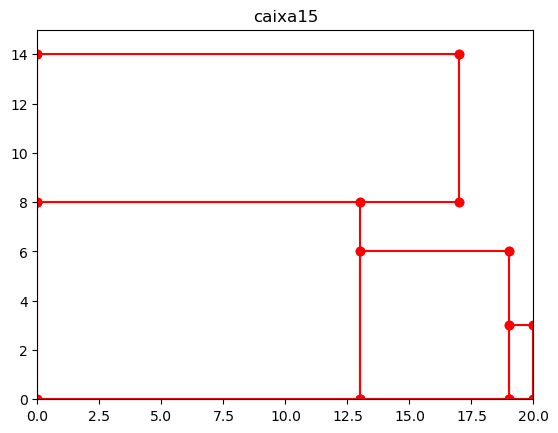

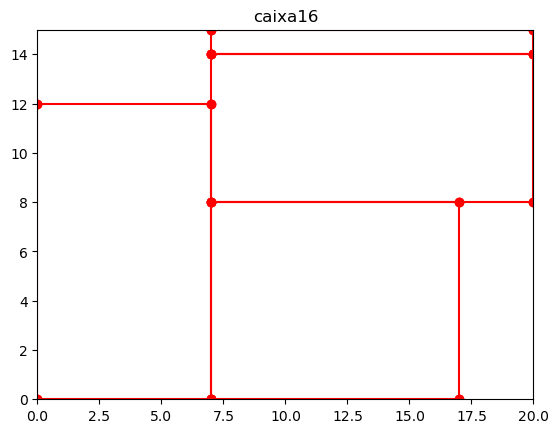

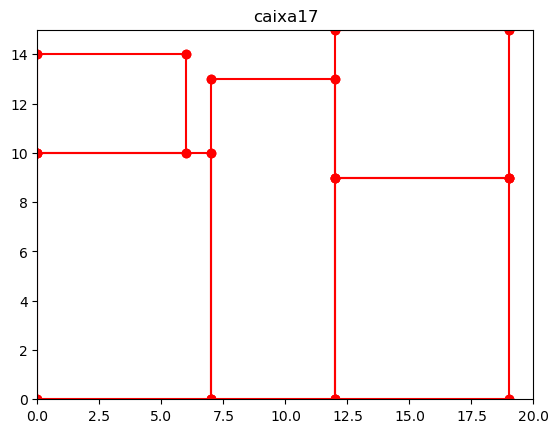

In [28]:
for caixa in list(dict_bins.keys()):
    plota_bin(dict_bins[caixa],caixa,'imagens/heuristica4/'+caixa,c_largura,c_altura)

Pelos resultados podemos ver que a heurística 2 (Coloca os itens ordenados na caixa) e a heurística 4 (coloca os itens ordenados na caixa ordenada) foram os que obtiveram melhor resultado geral com o uso de 17 caixas. Para obter melhores resultados seria necessário modificar o funcionamento da função atualiza_niveis para ela aproveitar o máximo de espaço possível, devido a falta de tempo não foi possível efetuar essa modificação.